In [1]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

In [2]:
# Downloading and Loading Dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=True)
 
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [3]:
# Fitting data loaders for iterating
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE,
                                          shuffle=False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    epochs = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        epochs.append(epoch+1)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"    Train loss: {round(mean_loss, 5)}")
        print(f"    Valid loss: {round(loss, 5)}")
        print(f"    Accuracy: {accuracy}%")
        print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc, epochs


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

### Implementing PyTorch LSTM model (using nn.LSTM)

In [6]:
class torch_LSTM(nn.Module):
    def __init__(self, input_dims, emd_dim, hidden_dim, num_layers, mode):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.mode = mode
        
        self.encoder = nn.Linear(in_features=input_dims, out_features=emd_dim)
        self.lstm = nn.LSTM(input_size=emd_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=10)
        return
    
    
    def forward(self, x):
        b_size, n_channels, n_rows, n_cols = x.shape
        h,c = self.init_state(b_size=b_size, device=x.device)
        
        x_rowed = x.view(b_size, n_channels*n_rows, n_cols)
        embeddings = self.encoder(x_rowed)
        
        lstm_out , (h_out, c_out) = self.lstm(embeddings, (h,c))
        
        y = self.classifier(lstm_out[:, -1, :])
        
        return y
    
    def init_state(self, b_size, device):
        if(self.mode == "zeros"):
            h = torch.zeros(self.num_layers, b_size, self.hidden_dim)
            c = torch.zeros(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "random"):
            h = torch.randn(self.num_layers, b_size, self.hidden_dim)
            c = torch.randn(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "learned"):
            h = self.learned_h.repeat(1, b_size, 1)
            c = self.learned_c.repeat(1, b_size, 1)
        h = h.to(device)
        c = c.to(device)
        return h, c

In [7]:
model_torch = torch_LSTM(input_dims=28, emd_dim=64, hidden_dim=128, num_layers=1 , mode="zeros")
model_torch=model_torch.to(device)
print(model_torch)

torch_LSTM(
  (encoder): Linear(in_features=28, out_features=64, bias=True)
  (lstm): LSTM(64, 128, batch_first=True)
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_torch.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [9]:
train_loss_lstm, val_loss_lstm, loss_iters_lstm, valid_acc_lstm, epochs_lstm = train_model(
        model=model_torch, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=20
    )

Epoch 1 Iter 235: loss 0.54936. : 100%|██████████████████████████████████████████████| 235/235 [00:08<00:00, 27.03it/s]


Epoch 1/20
    Train loss: 1.30459
    Valid loss: 2.30586
    Accuracy: 9.81%




Epoch 2 Iter 235: loss 0.21556. : 100%|██████████████████████████████████████████████| 235/235 [00:08<00:00, 27.08it/s]


Epoch 2/20
    Train loss: 0.33472
    Valid loss: 0.47245
    Accuracy: 86.8%




Epoch 3 Iter 235: loss 0.13334. : 100%|██████████████████████████████████████████████| 235/235 [00:08<00:00, 27.01it/s]


Epoch 3/20
    Train loss: 0.216
    Valid loss: 0.24606
    Accuracy: 93.11%




Epoch 4 Iter 235: loss 0.08589. : 100%|██████████████████████████████████████████████| 235/235 [00:08<00:00, 27.05it/s]


Epoch 4/20
    Train loss: 0.17022
    Valid loss: 0.17979
    Accuracy: 94.85%




Epoch 5 Iter 235: loss 0.18969. : 100%|██████████████████████████████████████████████| 235/235 [00:08<00:00, 26.77it/s]


Epoch 5/20
    Train loss: 0.13921
    Valid loss: 0.15142
    Accuracy: 95.65%




Epoch 6 Iter 235: loss 0.13138. : 100%|██████████████████████████████████████████████| 235/235 [00:08<00:00, 26.25it/s]


Epoch 6/20
    Train loss: 0.10998
    Valid loss: 0.13424
    Accuracy: 95.86%




Epoch 7 Iter 235: loss 0.16079. : 100%|██████████████████████████████████████████████| 235/235 [00:09<00:00, 25.79it/s]


Epoch 7/20
    Train loss: 0.10471
    Valid loss: 0.11718
    Accuracy: 96.63000000000001%




Epoch 8 Iter 235: loss 0.10236. : 100%|██████████████████████████████████████████████| 235/235 [00:09<00:00, 26.06it/s]


Epoch 8/20
    Train loss: 0.10056
    Valid loss: 0.1106
    Accuracy: 96.77%




Epoch 9 Iter 235: loss 0.07708. : 100%|██████████████████████████████████████████████| 235/235 [00:09<00:00, 25.90it/s]


Epoch 9/20
    Train loss: 0.09812
    Valid loss: 0.10738
    Accuracy: 96.83%




Epoch 10 Iter 235: loss 0.04966. : 100%|█████████████████████████████████████████████| 235/235 [00:09<00:00, 25.98it/s]


Epoch 10/20
    Train loss: 0.09393
    Valid loss: 0.10351
    Accuracy: 96.93%




Epoch 11 Iter 235: loss 0.21182. : 100%|█████████████████████████████████████████████| 235/235 [00:09<00:00, 25.51it/s]


Epoch 11/20
    Train loss: 0.08826
    Valid loss: 0.10158
    Accuracy: 96.94%




Epoch 12 Iter 235: loss 0.10467. : 100%|█████████████████████████████████████████████| 235/235 [00:09<00:00, 25.89it/s]


Epoch 12/20
    Train loss: 0.08691
    Valid loss: 0.09958
    Accuracy: 97.17%




Epoch 13 Iter 235: loss 0.03126. : 100%|█████████████████████████████████████████████| 235/235 [00:09<00:00, 25.36it/s]


Epoch 13/20
    Train loss: 0.08579
    Valid loss: 0.09827
    Accuracy: 97.11999999999999%




Epoch 14 Iter 235: loss 0.07332. : 100%|█████████████████████████████████████████████| 235/235 [00:09<00:00, 25.06it/s]


Epoch 14/20
    Train loss: 0.08541
    Valid loss: 0.09945
    Accuracy: 97.09%




Epoch 15 Iter 235: loss 0.10404. : 100%|█████████████████████████████████████████████| 235/235 [00:09<00:00, 25.95it/s]


Epoch 15/20
    Train loss: 0.08472
    Valid loss: 0.09686
    Accuracy: 97.26%




Epoch 16 Iter 235: loss 0.21269. : 100%|█████████████████████████████████████████████| 235/235 [00:09<00:00, 25.99it/s]


Epoch 16/20
    Train loss: 0.08377
    Valid loss: 0.09675
    Accuracy: 97.2%




Epoch 17 Iter 235: loss 0.07834. : 100%|█████████████████████████████████████████████| 235/235 [00:09<00:00, 26.04it/s]


Epoch 17/20
    Train loss: 0.08308
    Valid loss: 0.09593
    Accuracy: 97.24000000000001%




Epoch 18 Iter 235: loss 0.07300. : 100%|█████████████████████████████████████████████| 235/235 [00:09<00:00, 26.06it/s]


Epoch 18/20
    Train loss: 0.08289
    Valid loss: 0.09593
    Accuracy: 97.22%




Epoch 19 Iter 235: loss 0.06296. : 100%|█████████████████████████████████████████████| 235/235 [00:09<00:00, 26.03it/s]


Epoch 19/20
    Train loss: 0.0827
    Valid loss: 0.09574
    Accuracy: 97.25%




Epoch 20 Iter 235: loss 0.02653. : 100%|█████████████████████████████████████████████| 235/235 [00:09<00:00, 25.99it/s]

Epoch 20/20
    Train loss: 0.08245
    Valid loss: 0.09563
    Accuracy: 97.28999999999999%


Training completed


### Implementing own custom LSTM model without using nn.LSTM

In [10]:
class LSTM_Cells(torch.nn.Module):
   
    def __init__(self, in_dim, hidden_dim, bias=True):
        super(LSTM_Cells, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.bias = bias
        self.layer1 = nn.Linear(in_dim, 4 * hidden_dim, bias=bias)
        self.layer2 = nn.Linear(hidden_dim, 4 * hidden_dim, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_dim)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    
    def forward(self, x, hidden):
        
        x = x.view(-1, x.size(1))
        hx, cx = hidden
        
        gates = self.layer1(x) + self.layer2(hx)
        gates = gates.squeeze()
        
        input_gate, forget_gate, next_gate, out_gate = gates.chunk(4, 1)
        
        input_gate = torch.sigmoid(input_gate)
        
        forget_gate = torch.sigmoid(forget_gate)
        
        next_gate = torch.tanh(next_gate)
        
        out_gate = torch.sigmoid(out_gate)  
        
        c_y = forget_gate * cx + input_gate * next_gate
        h_y = out_gate * torch.tanh(c_y)
        
        return (c_y, h_y)
class Custom_LSTM(nn.Module):
    """ 
    Sequential classifier for images. Embedded image rows are fed to a RNN
    
    Args:
    -----
    input_dim: integer
        dimensionality of the rows to embed
    emb_dim: integer 
        dimensionality of the vectors fed to the LSTM
    hidden_dim: integer
        dimensionality of the states in the cell
    num_layers: integer
        number of stacked LSTMS
    mode: string
        intialization of the states
    """
    
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers=1, mode="zeros"):
        """ Module initializer """
        assert mode in ["zeros", "random", "learned"]
        super().__init__()
        self.hidden_dim =  hidden_dim
        self.input_dim =  input_dim
        self.num_layers = num_layers
        self.mode = mode
        if(mode == "learned"):
            self.learned_h = nn.Parameter(
                    torch.randn(num_layers, 1, hidden_dim).requires_grad_()
                )
            self.learned_c = nn.Parameter(
                    torch.randn(num_layers, 1, hidden_dim).requires_grad_()
                )
        
        # for embedding rows into vector representations
        self.encoder = nn.Linear(in_features=input_dim, out_features=emb_dim)

        lstms = []
        for i in range(num_layers):
            in_size = emb_dim if i == 0 else hidden_dim
            lstms.append(LSTM_Cells(in_dim=in_size, hidden_dim=hidden_dim))
        self.lstm = nn.ModuleList(lstms)
        
        # classifier
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=10)
        
        return
    

    def forward(self, x):
        """ Forward pass through model """
        
        b_size, n_channels, n_rows, n_cols = x.shape
        h, c = self.init_state(b_size=b_size, device=x.device) 
        
        # embedding rows
        x_rowed = x.view(b_size, n_channels*n_rows, n_cols)

        embeddings = self.encoder(x_rowed)


        lstm_out = []
        for i in range(embeddings.shape[1]):
            lstm_input = embeddings[:, i, :]
            # iterating over LSTM Cells
            for j, lstm_cell in enumerate(self.lstm):
                h[j], c[j] = lstm_cell(lstm_input, (h[j].clone(), c[j].clone()))
                lstm_input = h[j]
            lstm_out.append(lstm_input)
        lstm_out = torch.stack(lstm_out, dim=1)

        # classifying
        y = self.classifier(lstm_out[:, -1, :])  # feeding only output at last layer
        return y
    
        
    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = torch.zeros(self.num_layers, b_size, self.hidden_dim)
            c = torch.zeros(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "random"):
            h = torch.randn(self.num_layers, b_size, self.hidden_dim)
            c = torch.randn(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "learned"):
            h = self.learned_h.repeat(1, b_size, 1)
            c = self.learned_c.repeat(1, b_size, 1)
        h = h.to(device)
        c = c.to(device)
        return h, c

In [17]:
model_customlstm = Custom_LSTM(input_dim=28, emb_dim=64, hidden_dim=128, num_layers=1, mode="zeros")
count_model_params(model_customlstm)

102474

In [18]:
model_customlstm = model_customlstm.to(device)
print(model_customlstm)

Custom_LSTM(
  (encoder): Linear(in_features=28, out_features=64, bias=True)
  (lstm): ModuleList(
    (0): LSTM_Cells(
      (layer1): Linear(in_features=64, out_features=512, bias=True)
      (layer2): Linear(in_features=128, out_features=512, bias=True)
    )
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)


In [19]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_customlstm.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [20]:
train_loss_cuslstm, val_loss_cuslstm, loss_iters_cuslstm, valid_acc_cuslstm, epochs_cuslstm = train_model(
        model=model_customlstm, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=20
    )

Epoch 1 Iter 235: loss 0.84318. : 100%|██████████████████████████████████████████████| 235/235 [00:15<00:00, 14.69it/s]


Epoch 1/20
    Train loss: 1.41427
    Valid loss: 2.30502
    Accuracy: 10.23%




Epoch 2 Iter 235: loss 0.47863. : 100%|██████████████████████████████████████████████| 235/235 [00:14<00:00, 16.06it/s]


Epoch 2/20
    Train loss: 0.68903
    Valid loss: 0.92991
    Accuracy: 67.82000000000001%




Epoch 3 Iter 235: loss 0.30608. : 100%|██████████████████████████████████████████████| 235/235 [00:14<00:00, 15.96it/s]


Epoch 3/20
    Train loss: 0.41026
    Valid loss: 0.49754
    Accuracy: 84.82%




Epoch 4 Iter 235: loss 0.24518. : 100%|██████████████████████████████████████████████| 235/235 [00:15<00:00, 15.25it/s]


Epoch 4/20
    Train loss: 0.29167
    Valid loss: 0.31348
    Accuracy: 90.72%




Epoch 5 Iter 235: loss 0.17152. : 100%|██████████████████████████████████████████████| 235/235 [00:15<00:00, 15.20it/s]


Epoch 5/20
    Train loss: 0.23306
    Valid loss: 0.24376
    Accuracy: 92.84%




Epoch 6 Iter 235: loss 0.04916. : 100%|██████████████████████████████████████████████| 235/235 [00:15<00:00, 14.89it/s]


Epoch 6/20
    Train loss: 0.18948
    Valid loss: 0.21586
    Accuracy: 93.76%




Epoch 7 Iter 235: loss 0.24963. : 100%|██████████████████████████████████████████████| 235/235 [00:15<00:00, 15.17it/s]


Epoch 7/20
    Train loss: 0.18139
    Valid loss: 0.18552
    Accuracy: 94.57%




Epoch 8 Iter 235: loss 0.24843. : 100%|██████████████████████████████████████████████| 235/235 [00:16<00:00, 14.44it/s]


Epoch 8/20
    Train loss: 0.17422
    Valid loss: 0.17515
    Accuracy: 94.89999999999999%




Epoch 9 Iter 235: loss 0.12113. : 100%|██████████████████████████████████████████████| 235/235 [00:16<00:00, 14.67it/s]


Epoch 9/20
    Train loss: 0.16551
    Valid loss: 0.17171
    Accuracy: 95.03%




Epoch 10 Iter 235: loss 0.12825. : 100%|█████████████████████████████████████████████| 235/235 [00:15<00:00, 14.80it/s]


Epoch 10/20
    Train loss: 0.16009
    Valid loss: 0.17127
    Accuracy: 94.93%




Epoch 11 Iter 235: loss 0.07642. : 100%|█████████████████████████████████████████████| 235/235 [00:16<00:00, 14.19it/s]


Epoch 11/20
    Train loss: 0.15054
    Valid loss: 0.16057
    Accuracy: 95.43%




Epoch 12 Iter 235: loss 0.18496. : 100%|█████████████████████████████████████████████| 235/235 [00:16<00:00, 14.58it/s]


Epoch 12/20
    Train loss: 0.1491
    Valid loss: 0.15611
    Accuracy: 95.34%




Epoch 13 Iter 235: loss 0.14934. : 100%|█████████████████████████████████████████████| 235/235 [00:16<00:00, 14.48it/s]


Epoch 13/20
    Train loss: 0.14763
    Valid loss: 0.15555
    Accuracy: 95.32000000000001%




Epoch 14 Iter 235: loss 0.03069. : 100%|█████████████████████████████████████████████| 235/235 [00:16<00:00, 14.56it/s]


Epoch 14/20
    Train loss: 0.14596
    Valid loss: 0.15398
    Accuracy: 95.47%




Epoch 15 Iter 235: loss 0.08966. : 100%|█████████████████████████████████████████████| 235/235 [00:16<00:00, 14.32it/s]


Epoch 15/20
    Train loss: 0.14477
    Valid loss: 0.15271
    Accuracy: 95.48%




Epoch 16 Iter 235: loss 0.14309. : 100%|█████████████████████████████████████████████| 235/235 [00:15<00:00, 14.89it/s]


Epoch 16/20
    Train loss: 0.14281
    Valid loss: 0.15115
    Accuracy: 95.67999999999999%




Epoch 17 Iter 235: loss 0.20012. : 100%|█████████████████████████████████████████████| 235/235 [00:16<00:00, 14.35it/s]


Epoch 17/20
    Train loss: 0.14257
    Valid loss: 0.15029
    Accuracy: 95.56%




Epoch 18 Iter 235: loss 0.10022. : 100%|█████████████████████████████████████████████| 235/235 [00:15<00:00, 14.81it/s]


Epoch 18/20
    Train loss: 0.14187
    Valid loss: 0.15016
    Accuracy: 95.61%




Epoch 19 Iter 235: loss 0.20644. : 100%|█████████████████████████████████████████████| 235/235 [00:15<00:00, 14.78it/s]


Epoch 19/20
    Train loss: 0.14196
    Valid loss: 0.15053
    Accuracy: 95.53%




Epoch 20 Iter 235: loss 0.04206. : 100%|█████████████████████████████████████████████| 235/235 [00:15<00:00, 14.72it/s]

Epoch 20/20
    Train loss: 0.14128
    Valid loss: 0.14936
    Accuracy: 95.55%


Training completed


### Learning curves of the model trained using Pytorch LSTM and custom LSTM
#TODO
Add conv LSTM


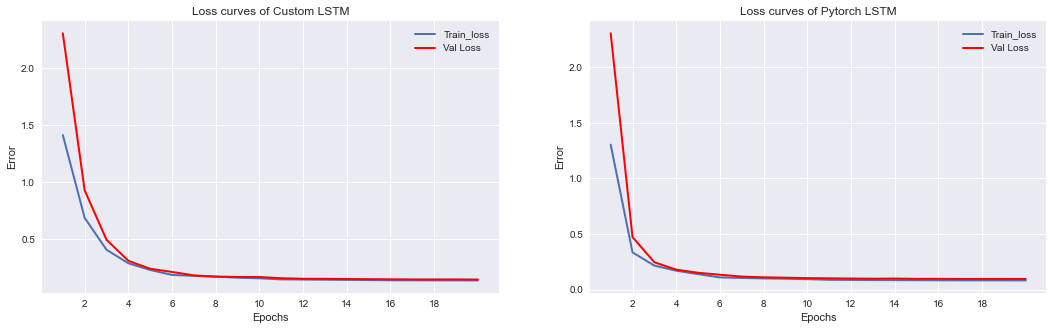

In [27]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18, 5)

ax[0].plot(epochs_cuslstm, train_loss_cuslstm, label="Train_loss", linewidth=2)
ax[0].plot(epochs_cuslstm, val_loss_cuslstm, label="Val Loss", c='red', linewidth=2)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
ax[0].set_xticks(np.arange(2, 19, step=2))

ax[0].set_title("Loss curves of Custom LSTM")

ax[1].plot(epochs_lstm, train_loss_lstm, label="Train_loss", linewidth=2)
ax[1].plot(epochs_lstm, val_loss_lstm , label="Val Loss", c='red', linewidth=2)
ax[1].legend(loc='best')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Error")
ax[1].set_xticks(np.arange(2, 19, step=2))

ax[1].set_title("Loss curves of Pytorch LSTM")


plt.show()

The curves show that the models have learned quite well and reach a stability point. The custom LSTM model works at par with Pytorchs inbuilt LSTM. However, it takes a little more time to reach stability(very minimal, almost negligible).


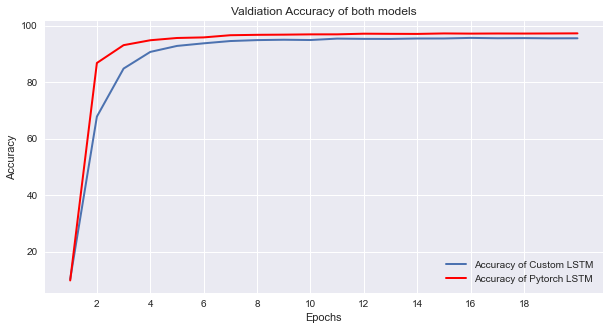

In [31]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 5)

ax.plot(epochs_cuslstm, valid_acc_cuslstm, linewidth=2,label="Accuracy of Custom LSTM")
ax.plot(epochs_lstm, valid_acc_lstm, label="Accuracy of Pytorch LSTM",c='red', linewidth=2)
ax.legend(loc='best')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_xticks(np.arange(2, 19, step=2))

ax.set_title(f"Valdiation Accuracy of both models")

plt.show()

Pytorch LSTM model reaches an accuracy of 97% while the custom LSTM reaches a maximum accuracy of 95%. 

### Implementing GRU

In [21]:
class GRU(nn.Module):

    def __init__(self, in_dim, hidden_dim, bias=True):
        super(GRU, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.bias = bias
        self.layer1 = nn.Linear(in_dim, 3 * hidden_dim, bias=bias)
        self.layer2 = nn.Linear(hidden_dim, 3 * hidden_dim, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_dim)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):

        x = x.view(-1, x.size(1))

        gate_x = self.layer1(x) 
        gate_h = self.layer2(hidden)

        gate_x = gate_x.squeeze()
        gate_h = gate_h.squeeze()
        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)


        reset_gate = torch.sigmoid(i_r + h_r)
        update_gate = torch.sigmoid(i_i + h_i)
        next_gate = torch.tanh(i_n + (reset_gate * h_n))

        h_y = next_gate + update_gate * (hidden - next_gate)

        return h_y

#create GRU model class
class GRUModel(nn.Module):
    def __init__(self, in_dim, emb_dim, hidden_dim, num_layers, out_size, bias=True, mode="zeros"):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.mode = mode
        self.encoder = nn.Linear(in_features=in_dim, out_features=emb_dim)
        
        grus = []
        for i in range(num_layers):
            in_size = emb_dim if i == 0 else hidden_dim
            grus.append(GRU(in_dim=in_size, hidden_dim=hidden_dim))
        self.gru = nn.ModuleList(grus)
        
        # classifier
        self.fc = nn.Linear(hidden_dim, out_size)
        
    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = torch.zeros(self.num_layers,b_size, self.hidden_dim).to(device) 
            c = torch.zeros(self.num_layers,b_size, self.hidden_dim).to(device) 
        elif(self.mode == "random"):
            h = torch.zeros(self.num_layers,b_size, self.hidden_dim).to(device) 
            c = torch.zeros(self.num_layers,b_size, self.hidden_dim).to(device) 
        return h, c
    
    
    def forward(self, x):
        b_size, n_channels, n_rows, n_cols = x.shape
        # Initialize hidden state with zeros
        h, c = self.init_state(b_size=b_size, device=x.device) 
        
        # embedding rows
        x_rowed = x.view(b_size, n_channels*n_rows, n_cols)

        embeddings = self.encoder(x_rowed)
        
        out = []
        for i in range(embeddings.shape[1]):
            gru_input = embeddings[:, i, :]
            # iterating over GRU Cells
            for j, lstm_cell in enumerate(self.gru):
                h[j] = lstm_cell(gru_input, (h[j].clone()))
                gru_input = h[j]
            out.append(gru_input)
        out = torch.stack(out, dim=1)

        # classifying
        y = self.fc(out[:, -1, :])  # feeding only output at last layer
        return y
        

In [22]:
model_GRU = GRUModel(in_dim=28, emb_dim=64, hidden_dim=128, num_layers=1,out_size=10, mode="zeros")
count_model_params(model_GRU)

77642

In [23]:
model_GRU = model_GRU.to(device)
print(model_GRU)

GRUModel(
  (encoder): Linear(in_features=28, out_features=64, bias=True)
  (gru): ModuleList(
    (0): GRU(
      (layer1): Linear(in_features=64, out_features=384, bias=True)
      (layer2): Linear(in_features=128, out_features=384, bias=True)
    )
  )
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [24]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_GRU.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [25]:
train_loss_gru, val_loss_gru, loss_iters_gru, valid_acc_gru, epochs_gru = train_model(
        model=model_GRU, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=20
    )

Epoch 1 Iter 235: loss 0.80896. : 100%|██████████████████████████████████████████████| 235/235 [00:15<00:00, 15.35it/s]


Epoch 1/20
    Train loss: 1.48464
    Valid loss: 2.30677
    Accuracy: 9.8%




Epoch 2 Iter 235: loss 0.49805. : 100%|██████████████████████████████████████████████| 235/235 [00:15<00:00, 15.44it/s]


Epoch 2/20
    Train loss: 0.61179
    Valid loss: 0.78551
    Accuracy: 76.02%




Epoch 3 Iter 235: loss 0.18038. : 100%|██████████████████████████████████████████████| 235/235 [00:15<00:00, 15.58it/s]


Epoch 3/20
    Train loss: 0.38162
    Valid loss: 0.44842
    Accuracy: 86.42%




Epoch 4 Iter 235: loss 0.12133. : 100%|██████████████████████████████████████████████| 235/235 [00:15<00:00, 15.63it/s]


Epoch 4/20
    Train loss: 0.27297
    Valid loss: 0.3079
    Accuracy: 90.48%




Epoch 5 Iter 235: loss 0.32854. : 100%|██████████████████████████████████████████████| 235/235 [00:15<00:00, 15.48it/s]


Epoch 5/20
    Train loss: 0.21069
    Valid loss: 0.21729
    Accuracy: 93.52000000000001%




Epoch 6 Iter 235: loss 0.07699. : 100%|██████████████████████████████████████████████| 235/235 [00:15<00:00, 15.42it/s]


Epoch 6/20
    Train loss: 0.17521
    Valid loss: 0.18067
    Accuracy: 94.71000000000001%




Epoch 7 Iter 235: loss 0.10671. : 100%|██████████████████████████████████████████████| 235/235 [00:15<00:00, 15.59it/s]


Epoch 7/20
    Train loss: 0.16784
    Valid loss: 0.16429
    Accuracy: 95.19%




Epoch 8 Iter 235: loss 0.13321. : 100%|██████████████████████████████████████████████| 235/235 [00:15<00:00, 15.38it/s]


Epoch 8/20
    Train loss: 0.16135
    Valid loss: 0.15806
    Accuracy: 95.30999999999999%




Epoch 9 Iter 235: loss 0.24852. : 100%|██████████████████████████████████████████████| 235/235 [00:15<00:00, 15.42it/s]


Epoch 9/20
    Train loss: 0.15578
    Valid loss: 0.15238
    Accuracy: 95.47%




Epoch 10 Iter 235: loss 0.33528. : 100%|█████████████████████████████████████████████| 235/235 [00:15<00:00, 15.59it/s]


Epoch 10/20
    Train loss: 0.15015
    Valid loss: 0.14453
    Accuracy: 95.78%




Epoch 11 Iter 235: loss 0.17730. : 100%|█████████████████████████████████████████████| 235/235 [00:15<00:00, 15.42it/s]


Epoch 11/20
    Train loss: 0.1442
    Valid loss: 0.14207
    Accuracy: 95.78999999999999%




Epoch 12 Iter 235: loss 0.08392. : 100%|█████████████████████████████████████████████| 235/235 [00:14<00:00, 15.74it/s]


Epoch 12/20
    Train loss: 0.14268
    Valid loss: 0.13951
    Accuracy: 95.87%




Epoch 13 Iter 235: loss 0.17974. : 100%|█████████████████████████████████████████████| 235/235 [00:14<00:00, 15.86it/s]


Epoch 13/20
    Train loss: 0.1418
    Valid loss: 0.13818
    Accuracy: 95.99%




Epoch 14 Iter 235: loss 0.09972. : 100%|█████████████████████████████████████████████| 235/235 [00:15<00:00, 15.44it/s]


Epoch 14/20
    Train loss: 0.14055
    Valid loss: 0.13719
    Accuracy: 95.93%




Epoch 15 Iter 235: loss 0.07686. : 100%|█████████████████████████████████████████████| 235/235 [00:15<00:00, 15.22it/s]


Epoch 15/20
    Train loss: 0.13935
    Valid loss: 0.13635
    Accuracy: 95.95%




Epoch 16 Iter 235: loss 0.09979. : 100%|█████████████████████████████████████████████| 235/235 [00:15<00:00, 15.25it/s]


Epoch 16/20
    Train loss: 0.1382
    Valid loss: 0.1351
    Accuracy: 95.96000000000001%




Epoch 17 Iter 235: loss 0.18482. : 100%|█████████████████████████████████████████████| 235/235 [00:15<00:00, 15.41it/s]


Epoch 17/20
    Train loss: 0.13822
    Valid loss: 0.13502
    Accuracy: 95.98%




Epoch 18 Iter 235: loss 0.10933. : 100%|█████████████████████████████████████████████| 235/235 [00:15<00:00, 15.45it/s]


Epoch 18/20
    Train loss: 0.13776
    Valid loss: 0.13478
    Accuracy: 95.99%




Epoch 19 Iter 235: loss 0.02442. : 100%|█████████████████████████████████████████████| 235/235 [00:15<00:00, 15.44it/s]


Epoch 19/20
    Train loss: 0.13731
    Valid loss: 0.1345
    Accuracy: 95.98%




Epoch 20 Iter 235: loss 0.10647. : 100%|█████████████████████████████████████████████| 235/235 [00:15<00:00, 15.56it/s]

Epoch 20/20
    Train loss: 0.13731
    Valid loss: 0.13439
    Accuracy: 96.00999999999999%


Training completed


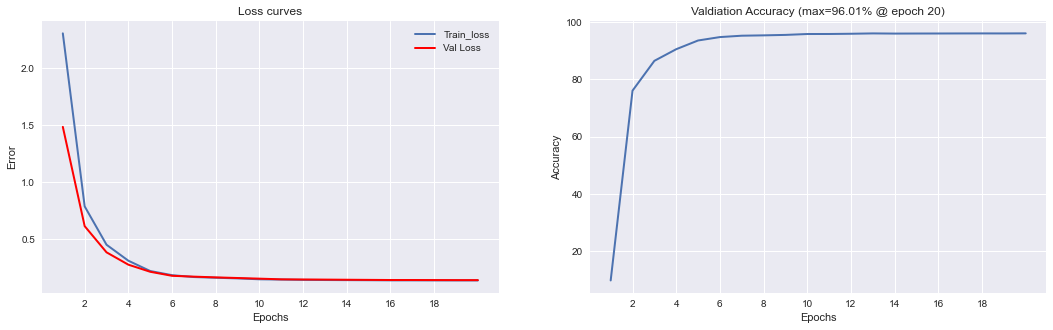

In [26]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18, 5)

ax[0].plot(epochs_gru, val_loss_gru, label="Train_loss", linewidth=2)
ax[0].plot(epochs_gru, train_loss_gru, label="Val Loss", c='red', linewidth=2)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
ax[0].set_xticks(np.arange(2, 19, step=2))

ax[0].set_title("Loss curves")


ax[1].plot(epochs_gru, valid_acc_gru, label="Accuracy", linewidth=2)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_xticks(np.arange(2, 19, step=2))

ax[1].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc_gru),2)}% @ epoch {np.argmax(valid_acc_gru)+1})")

plt.show()

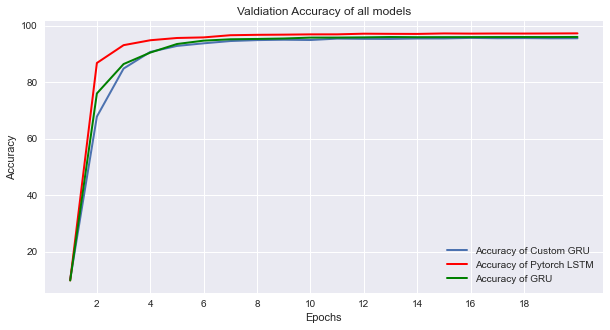

In [29]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 5)

ax.plot(epochs_cuslstm, valid_acc_cuslstm, linewidth=2,label="Accuracy of Custom GRU")
ax.plot(epochs_lstm, valid_acc_lstm, label="Accuracy of Pytorch LSTM",c='red', linewidth=2)
ax.plot(epochs_gru, valid_acc_gru, label="Accuracy of GRU",c='green', linewidth=2)
ax.legend(loc='best')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_xticks(np.arange(2, 19, step=2))

ax.set_title(f"Valdiation Accuracy of all models")

plt.show()

Model trained with GRU achieves almost the same results as the model trained using Pytorchs LSTM.

## References
https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
